# 1| Importing some modules

In [1]:
# Import system libraries for file operations and timing
import os

# Import data handling and visualization tools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Import machine learning libraries for RandomForest and XGBoost
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# 2| Creating some functions and create dataframe

In [2]:
# Generate data paths with labels from directory structure
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe (to later be fitted into the model)
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

# Split dataframe to train, valid, and test sets
def split_data(data_dir):
    # Create train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Create validation and test dataframes
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

# 3| Function to preprocess images for RandomForest and XGBoost

In [ ]:
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def create_gens(train_df, valid_df, test_df, target_size=(64, 64), batch_size=100, max_workers=4):
    
    
    def preprocess_image_safe(img_path, target_size):
        """
        Préprocessing sécurisé avec gestion d'erreurs complète
        """
        try:
            # Vérifier que le fichier existe
            if not os.path.exists(img_path):
                print(f"Fichier non trouvé: {img_path}")
                return None
                
            # Charger l'image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Impossible de lire l'image: {img_path}")
                return None
            
            # Redimensionner en premier pour économiser la mémoire
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            
            # Convertir en niveaux de gris
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Normalisation efficace
            img = img.astype(np.float32) / 255.0
            
            # Aplatir l'image pour Random Forest/XGBoost
            img_flat = img.flatten()
            
            return img_flat
            
        except Exception as e:
            print(f"Erreur lors du traitement de {img_path}: {str(e)}")
            return None

    def process_batch(filepaths_batch, target_size, pbar):
        """
        Traiter un batch d'images avec gestion mémoire
        """
        batch_images = []
        
        # Traitement séquentiel du batch pour éviter les problèmes de mémoire
        for filepath in filepaths_batch:
            img = preprocess_image_safe(filepath, target_size)
            if img is not None:
                batch_images.append(img)
            pbar.update(1)
        
        return batch_images

    def preprocess_dataset(df, dataset_name, target_size, batch_size, max_workers):
        """
        Préprocesser un dataset complet par batches
        """
        print(f"\nTraitement du dataset {dataset_name} ({len(df)} images)...")
        
        filepaths = df['filepaths'].tolist()
        all_images = []
        
        # Diviser en batches
        batches = [filepaths[i:i + batch_size] for i in range(0, len(filepaths), batch_size)]
        
        with tqdm(total=len(filepaths), desc=f"Processing {dataset_name}") as pbar:
            # Traitement par batches avec threads limités
            with ThreadPoolExecutor(max_workers=min(max_workers, 2)) as executor:
                futures = []
                
                for batch in batches:
                    future = executor.submit(process_batch, batch, target_size, pbar)
                    futures.append(future)
                
                # Récupérer les résultats au fur et à mesure
                for future in as_completed(futures):
                    try:
                        batch_result = future.result(timeout=300)  # 5 min timeout
                        all_images.extend(batch_result)
                        
                        # Nettoyage mémoire périodique
                        if len(all_images) % (batch_size * 5) == 0:
                            gc.collect()
                            
                    except Exception as e:
                        print(f"Erreur dans le batch: {str(e)}")
                        continue
        
        print(f"Dataset {dataset_name}: {len(all_images)}/{len(df)} images traitées avec succès")
        
        if len(all_images) == 0:
            raise ValueError(f"Aucune image n'a pu être traitée pour {dataset_name}")
        
        return np.array(all_images, dtype=np.float32)

    try:
        
        # Dataset d'entraînement
        train_images = preprocess_dataset(train_df, "TRAIN", target_size, batch_size, max_workers)
        train_labels = train_df['labels'].values
        gc.collect()  # Nettoyage mémoire
        
        # Dataset de validation
        valid_images = preprocess_dataset(valid_df, "VALIDATION", target_size, batch_size, max_workers)
        valid_labels = valid_df['labels'].values
        gc.collect()
        
        # Dataset de test
        test_images = preprocess_dataset(test_df, "TEST", target_size, batch_size, max_workers)
        test_labels = test_df['labels'].values
        gc.collect()
 
        return train_images, train_labels, valid_images, valid_labels, test_images, test_labels
        
    except Exception as e:
        print(f"ERREUR CRITIQUE: {str(e)}")
        # Nettoyage en cas d'erreur
        gc.collect()
        raise

# VERSION ENCORE PLUS SIMPLE (si la version ci-dessus crash encore)
def create_gens_simple(train_df, valid_df, test_df, target_size=(32, 32)):
    """
    Version ultra-simplifiée sans parallélisation
    À utiliser si la version parallèle cause toujours des crashes
    """
    
    def preprocess_simple(filepath):
        try:
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                return None
            img = cv2.resize(img, target_size)
            return (img.astype(np.float32) / 255.0).flatten()
        except:
            return None
    
    def process_df_simple(df, name):
        print(f"Traitement {name}...")
        images = []
        for i, filepath in enumerate(tqdm(df['filepaths'])):
            if i % 1000 == 0:  # Nettoyage périodique
                gc.collect()
            img = preprocess_simple(filepath)
            if img is not None:
                images.append(img)
        return np.array(images, dtype=np.float32)
    
    train_images = process_df_simple(train_df, "TRAIN")
    valid_images = process_df_simple(valid_df, "VALID")
    test_images = process_df_simple(test_df, "TEST")
    
    return (train_images, train_df['labels'].values,
            valid_images, valid_df['labels'].values,
            test_images, test_df['labels'].values)


# 4| Function to display data sample (adapted for traditional ML)

In [4]:
def show_sample_images(df, num_samples=25):
    # Display sample images from the dataframe for visual inspection
    # This function is adapted for use with pandas DataFrames instead of Keras generators
    
    sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)
    
    plt.figure(figsize=(20, 20))
    
    for i, (idx, row) in enumerate(sample_df.iterrows()):
        if i >= 25:  # Limit to 25 images
            break
            
        plt.subplot(5, 5, i + 1)
        
        # Load and display image
        img = cv2.imread(row['filepaths'])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
            plt.title(row['labels'], color='blue', fontsize=12)
        else:
            plt.text(0.5, 0.5, 'Image not found', ha='center', va='center')
            plt.title(row['labels'], color='red', fontsize=12)
            
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 5| Data Loading and Preparation

Loading and splitting data...
Data loading and splitting complete.

Class distribution in training set:
labels
Soybean___healthy                                1618
Apple___Apple_scab                               1613
Orange___Haunglongbing_(Citrus_greening)         1608
Apple___healthy                                  1606
Pepper,_bell___healthy                           1590
Apple___Black_rot                                1590
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1569
Potato___Early_blight                            1551
Potato___Late_blight                             1551
Tomato___healthy                                 1541
Tomato___Early_blight                            1536
Grape___Esca_(Black_Measles)                     1536
Pepper,_bell___Bacterial_spot                    1530
Corn_(maize)___Common_rust_                      1526
Grape___Black_rot                                1510
Corn_(maize)___healthy                           1487
Peach___Bacterial_spot   

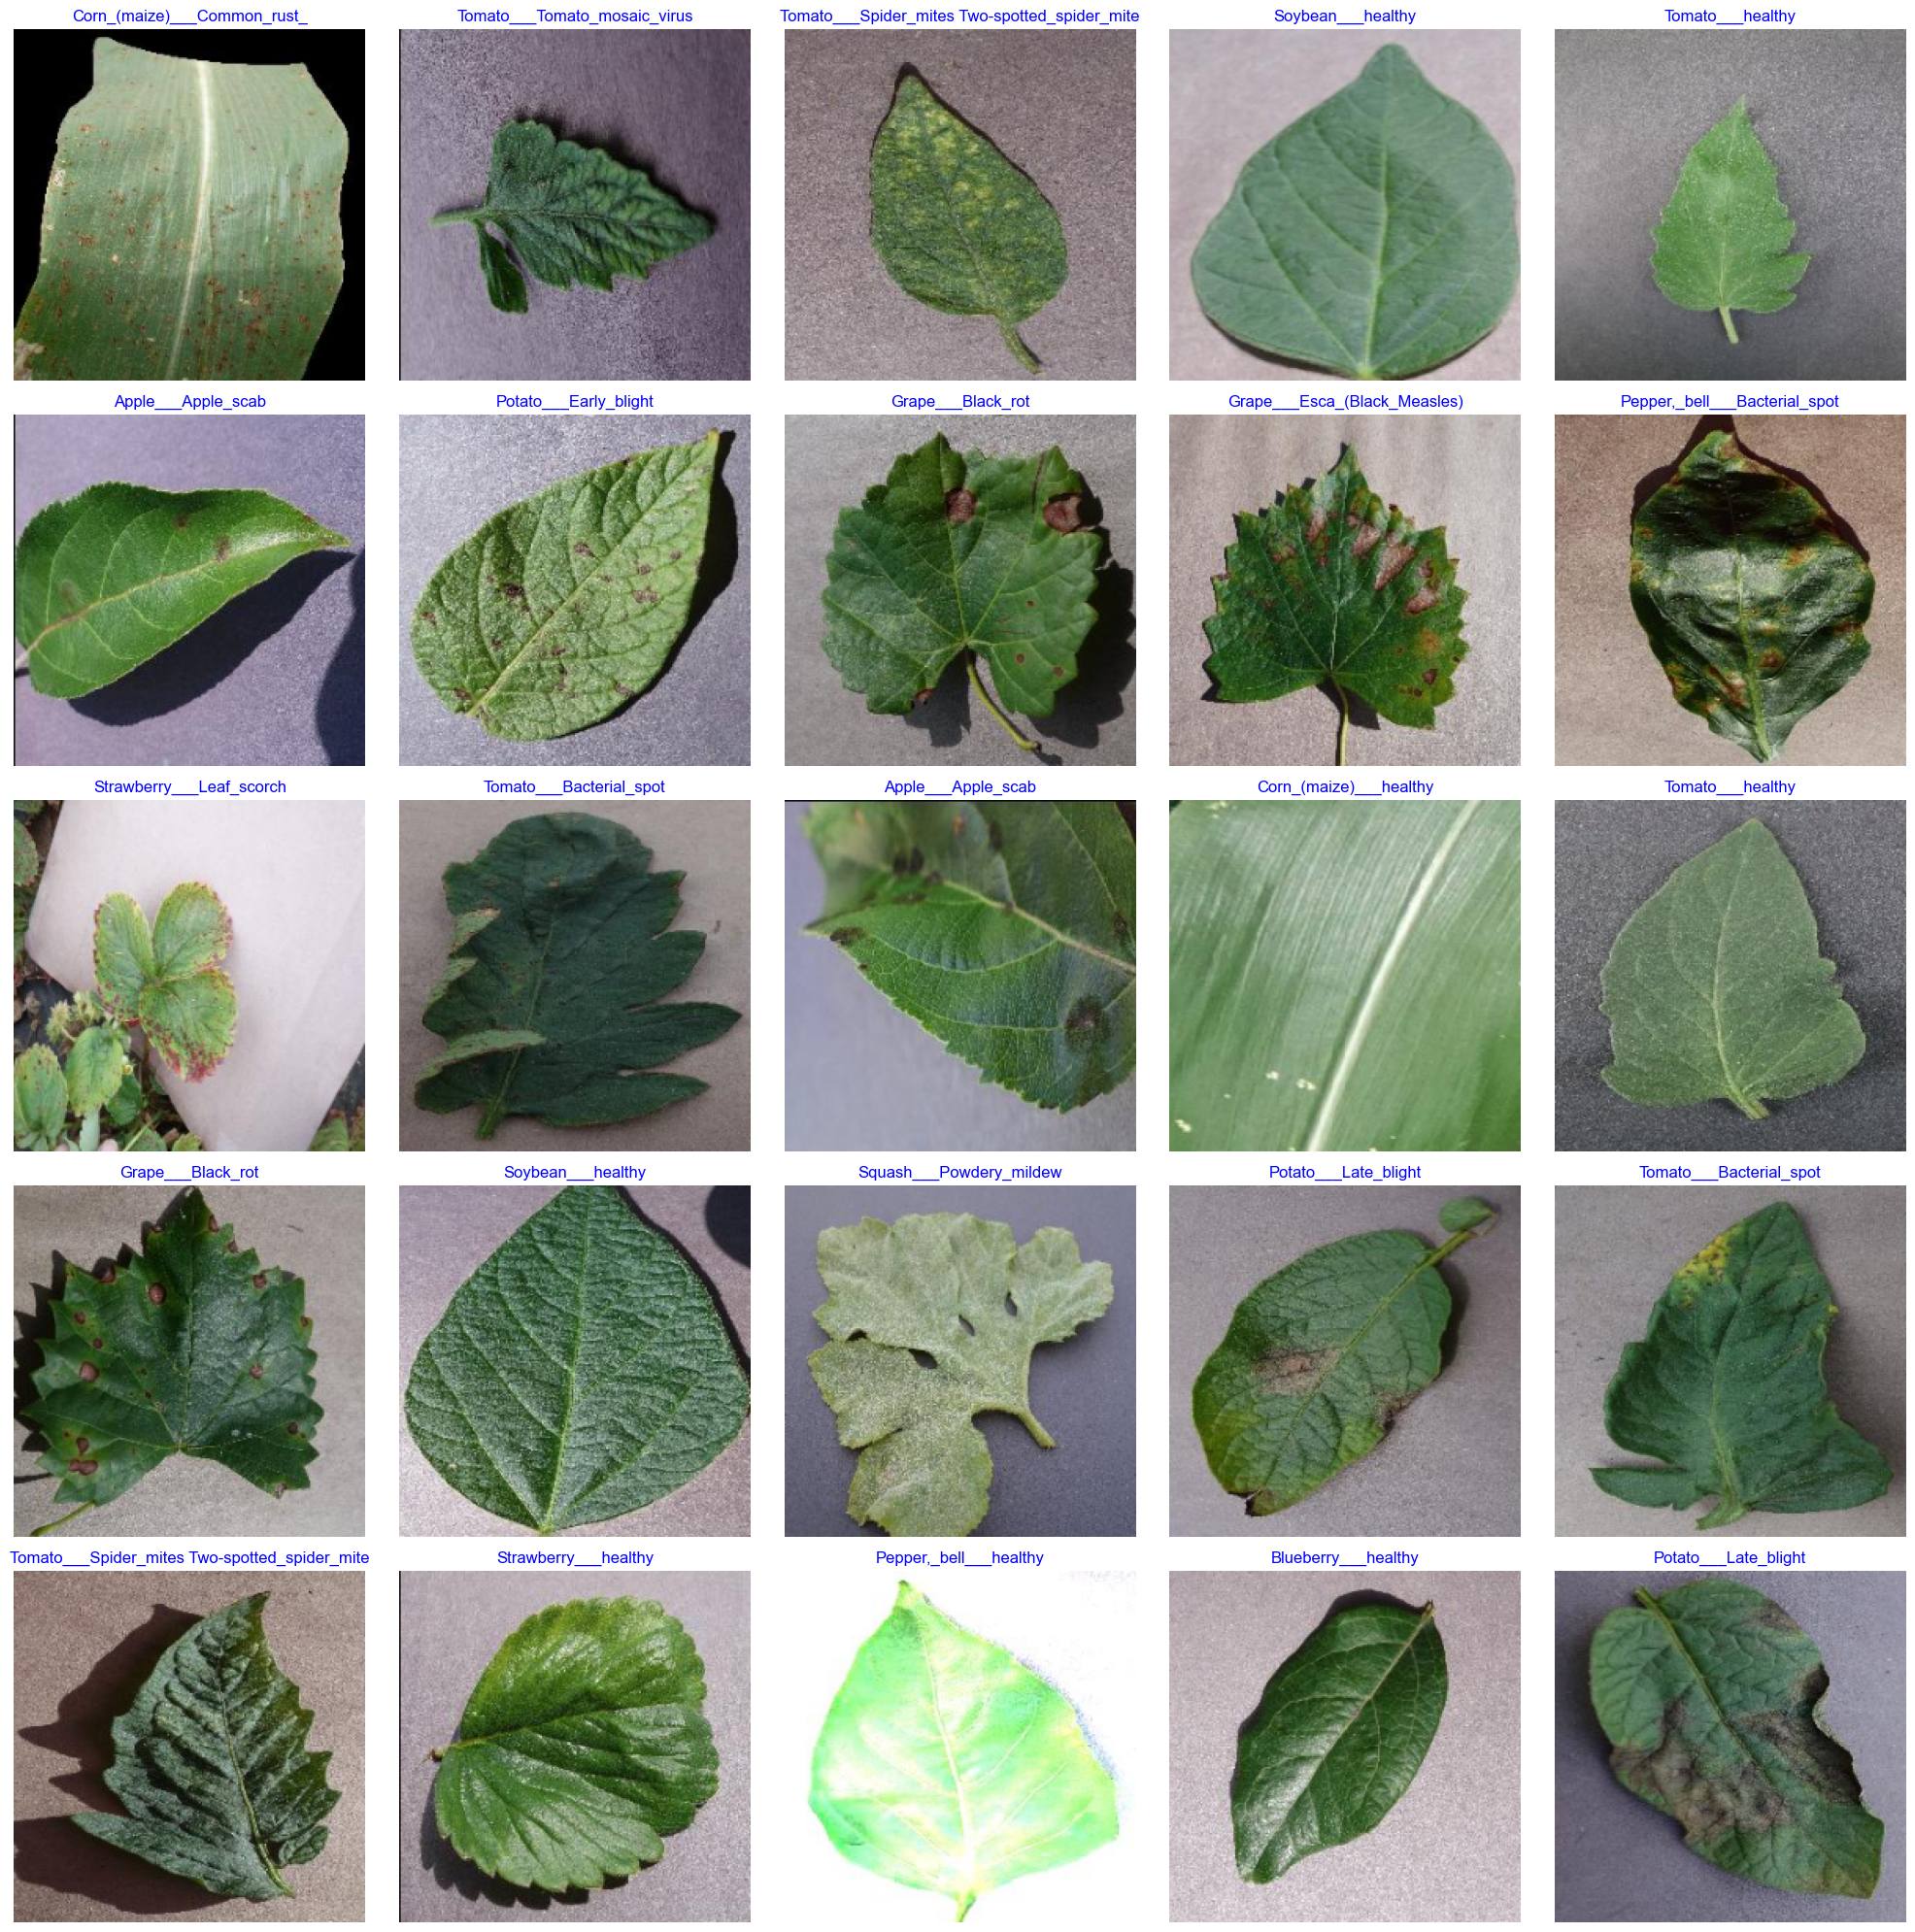

In [5]:
# Load and prepare the data
# Note: Update the data_dir path to point to your plant disease dataset
data_dir =  r'C:\Users\Abdel\Downloads\data-plant-diseases\data' # Change this to your actual data directory
# sampled-plant-disease-dataset
print("Loading and splitting data...")
train_df, valid_df, test_df = split_data(data_dir)
print("Data loading and splitting complete.")

# Display class distribution
print("\nClass distribution in training set:")
print(train_df['labels'].value_counts())

# Show sample images
print("\nDisplaying sample images from training set...")
show_sample_images(train_df)

# 6| Image Preprocessing for Machine Learning Models

In [6]:
# Preprocess images and prepare data for RandomForest and XGBoost
print("Preprocessing images...")
try:
    # Commencez avec des paramètres conservateurs
    train_data, train_labels, valid_data, valid_labels, test_data, test_labels = create_gens(
        train_df, valid_df, test_df,
        target_size=(64, 64),    # Réduire si crash (32x32 ou 48x48)
        batch_size=50,           # Réduire si crash (25 ou 10)
        max_workers=2            # Réduire à 1 si crash
    )
except:
    print("Version parallèle a échoué, utilisation de la version simple...")
    train_data, train_labels, valid_data, valid_labels, test_data, test_labels = create_gens_simple(
        train_df, valid_df, test_df,
        target_size=(32, 32)
    )
print("Image preprocessing complete.")

# Encode labels to numerical values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Preprocessing images...
=== DÉBUT DU PRÉPROCESSING ===
Paramètres: taille=(64, 64), batch_size=50, workers=2

Traitement du dataset TRAIN (44739 images)...


Processing TRAIN: 100%|██████████| 44739/44739 [03:44<00:00, 199.21it/s]


Dataset TRAIN: 44739/44739 images traitées avec succès

Traitement du dataset VALIDATION (5592 images)...


Processing VALIDATION: 100%|██████████| 5592/5592 [00:28<00:00, 194.07it/s]


Dataset VALIDATION: 5592/5592 images traitées avec succès

Traitement du dataset TEST (5593 images)...


Processing TEST: 100%|██████████| 5593/5593 [00:29<00:00, 191.55it/s]


Dataset TEST: 5593/5593 images traitées avec succès

=== RÉSUMÉ ===
Train: (44739, 4096)
Valid: (5592, 4096)
Test: (5593, 4096)
=== PRÉPROCESSING TERMINÉ AVEC SUCCÈS ===
Image preprocessing complete.
Training data shape: (44739, 4096)
Validation data shape: (5592, 4096)
Test data shape: (5593, 4096)
Number of classes: 30
Classes: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy' 'Corn_(maize)___Common_rust_'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Raspberry___healthy' 'Soybean___healthy' 'Squash___Powdery_mildew'
 'Strawberry___Leaf_scorch' 'Strawberry___healthy'
 'Tomato__

# 7| RandomForest Classifier with Hyperparameter Tuning

In [ ]:
# Train RandomForest classifier with hyperparameter tuning
print("Training RandomForest Classifier...")

# Define parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomForest classifier
rf = RandomForestClassifier(random_state=123, n_jobs=-1)

# Use RandomizedSearchCV for efficiency with large parameter space
random_search_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid_rf, 
    n_iter=20,  # Number of parameter settings sampled
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    random_state=123,
    scoring='accuracy'
)
# {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}

# Fit the model
random_search_rf.fit(train_data, train_labels_encoded)

# Get the best estimator
best_rf = random_search_rf.best_estimator_

print(f"Best RandomForest parameters: {random_search_rf.best_params_}")
print(f"Best cross-validation score: {random_search_rf.best_score_:.4f}")

Training RandomForest Classifier...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RandomForest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best cross-validation score: 0.5868


# 8| XGBoost Classifier with Hyperparameter Tuning

In [ ]:
# Train XGBoost classifier with hyperparameter tuning
print("Training XGBoost Classifier...")

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(
    random_state=123, 
    n_jobs=-1,
    use_label_encoder=False, 
    eval_metric='mlogloss'
)

# Use RandomizedSearchCV for efficiency
random_search_xgb = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_grid_xgb, 
    n_iter=20,  # Number of parameter settings sampled
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    random_state=123,
    scoring='accuracy'
)

# Fit the model
random_search_xgb.fit(train_data, train_labels_encoded)

# Get the best estimator
best_xgb = random_search_xgb.best_estimator_

print(f"Best XGBoost parameters: {random_search_xgb.best_params_}")
print(f"Best cross-validation score: {random_search_xgb.best_score_:.4f}")

Training XGBoost Classifier...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


# 9| Model Evaluation and Comparison

In [ ]:
# Evaluate both models on validation and test sets
print("Evaluating models...")

# RandomForest predictions
rf_valid_pred = best_rf.predict(valid_data)
rf_test_pred = best_rf.predict(test_data)

# XGBoost predictions
xgb_valid_pred = best_xgb.predict(valid_data)
xgb_test_pred = best_xgb.predict(test_data)

# Calculate accuracies
rf_valid_acc = accuracy_score(valid_labels_encoded, rf_valid_pred)
rf_test_acc = accuracy_score(test_labels_encoded, rf_test_pred)
xgb_valid_acc = accuracy_score(valid_labels_encoded, xgb_valid_pred)
xgb_test_acc = accuracy_score(test_labels_encoded, xgb_test_pred)

print("MODEL PERFORMANCE COMPARISON")
print(f"RandomForest - Validation Accuracy: {rf_valid_acc:.4f}")
print(f"RandomForest - Test Accuracy: {rf_test_acc:.4f}")
print(f"XGBoost - Validation Accuracy: {xgb_valid_acc:.4f}")
print(f"XGBoost - Test Accuracy: {xgb_test_acc:.4f}")

# 10| Detailed Classification Report

In [ ]:
# Generate detailed classification reports for both models
print("\nRANDOMFOREST CLASSIFICATION REPORT:")
rf_report = classification_report(
    test_labels_encoded, 
    rf_test_pred, 
    target_names=label_encoder.classes_,
    digits=4
)
print(rf_report)

print("\nXGBOOST CLASSIFICATION REPORT:")
print("="*50)
xgb_report = classification_report(
    test_labels_encoded, 
    xgb_test_pred, 
    target_names=label_encoder.classes_,
    digits=4
)
print(xgb_report)

# 11| Confusion Matrix Visualization

In [ ]:
# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# RandomForest confusion matrix
rf_cm = confusion_matrix(test_labels_encoded, rf_test_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[0])
axes[0].set_title(f'RandomForest Confusion Matrix\nAccuracy: {rf_test_acc:.4f}', fontsize=14)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# XGBoost confusion matrix
xgb_cm = confusion_matrix(test_labels_encoded, xgb_test_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[1])
axes[1].set_title(f'XGBoost Confusion Matrix\nAccuracy: {xgb_test_acc:.4f}', fontsize=14)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# 12| Feature Importance Analysis

In [ ]:
# Analyze feature importance for both models
print("Analyzing feature importance...")

# Get feature importances
rf_importance = best_rf.feature_importances_
xgb_importance = best_xgb.feature_importances_

# Create feature importance plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot top 50 features for RandomForest
top_indices_rf = np.argsort(rf_importance)[-50:]
axes[0].barh(range(50), rf_importance[top_indices_rf])
axes[0].set_title('Top 50 Feature Importances - RandomForest')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature Index')

# Plot top 50 features for XGBoost
top_indices_xgb = np.argsort(xgb_importance)[-50:]
axes[1].barh(range(50), xgb_importance[top_indices_xgb])
axes[1].set_title('Top 50 Feature Importances - XGBoost')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature Index')

plt.tight_layout()
plt.show()

print(f"\nRandomForest - Top 10 most important features: {top_indices_rf[-10:]}")
print(f"XGBoost - Top 10 most important features: {top_indices_xgb[-10:]}")

# 13| Model Performance Summary

In [ ]:
# Create a comprehensive performance summary
performance_summary = pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost'],
    'Validation_Accuracy': [rf_valid_acc, xgb_valid_acc],
    'Test_Accuracy': [rf_test_acc, xgb_test_acc],
    'Best_CV_Score': [random_search_rf.best_score_, random_search_xgb.best_score_]
})

print("\nPERFORMANCE SUMMARY:")
print(performance_summary.to_string(index=False, float_format='%.4f'))


# Create performance comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
models = ['RandomForest', 'XGBoost']
valid_accs = [rf_valid_acc, xgb_valid_acc]
test_accs = [rf_test_acc, xgb_test_acc]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, valid_accs, width, label='Validation', alpha=0.8)
axes[0].bar(x + width/2, test_accs, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Cross-validation score comparison
cv_scores = [random_search_rf.best_score_, random_search_xgb.best_score_]
axes[2].bar(models, cv_scores, alpha=0.8, color=['orange', 'purple'])
axes[2].set_xlabel('Models')
axes[2].set_ylabel('Best CV Score')
axes[2].set_title('Cross-Validation Score Comparison')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()